In [1]:
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dataset
df = pd.read_csv('C:\\Users\\MoLin\\Desktop\\Mora\\Python\\OnlineRetail.csv', encoding = 'ISO-8859-1')

# EDA

Do a Pandas Profiling Report to know more about the dataset. However, this can be slow, depends on PC and dataset. #import pandas_profiling; #df.profile_report()
So I simply describe the data to understand a bit more of it.

In [3]:
df.describe(include = 'all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


# Data Cleaning

In [4]:
#notice that CustomerID has some missing value, so i will drop that row that has a missing value, data is useless\
#if we don't know who is the customer
df.dropna(inplace = True)

In [5]:
#notice there's a negative value in the column of Quantity and UnitPrice, so I drop those rows by filtering where\
# Quantity > 0 and UnitPrice >0
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [6]:
#notice that InvoiceDate is categorical not date format, so need to convert it to date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [7]:
#notice that we only have quantity and unitprice but we need sales data
df['Sales'] = df.Quantity * df.UnitPrice

In [8]:
#ok now let's have a look at what the data looks like
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [9]:
#great. but we don't need all the columns, we only need CustomerID, InvoiceDate and Sales
df = df[['CustomerID','InvoiceDate','Sales']]
df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


# RFM Data Transformation

!pip install lifetimes if there's no lifetimes module installed.

In [10]:
from lifetimes.utils import summary_data_from_transaction_data
df_rfm = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col = 'Sales',
                                           observation_period_end = df['InvoiceDate'].max())
df_rfm.describe()

,frequency,recency,T,monetary_value
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,2.864223,130.771554,222.831028,307.028848
std,5.949000,132.210509,117.854570,2612.749850
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,177.064773
75%,3.000000,252.000000,326.000000,360.162500
max,131.000000,373.000000,373.000000,168469.600000


# Now that we have prepared our data in the desired format, we can fit a model.

In [11]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef = 0)
bgf.fit(df_rfm['frequency'], df_rfm['recency'], df_rfm['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 68.91, b: 6.75, r: 0.83>

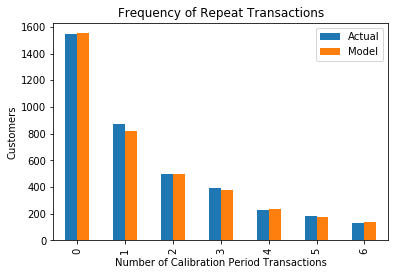

In [13]:
from lifetimes.plotting import *
plot_period_transactions(bgf)

The model looks ok. But let's do some more validation.

In [14]:
#split data into training set and testing set
from lifetimes.utils import calibration_and_holdout_data
df_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate', \
                                              calibration_period_end='2011-07-01', \
                                              observation_period_end='2011-12-09' )
df_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,164.0,0.0,161
12347.0,3.0,184.0,206.0,3.0,161
12348.0,2.0,110.0,197.0,1.0,161
12350.0,0.0,0.0,149.0,0.0,161
12352.0,3.0,34.0,135.0,3.0,161


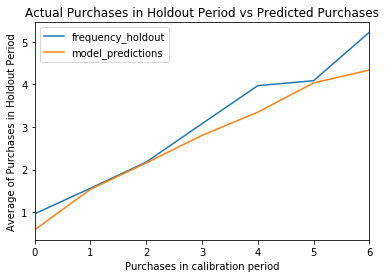

In [15]:
#see how's the model perform in the testing set.
bgf = BetaGeoFitter(penalizer_coef = 0.05)
bgf.fit(df_cal_holdout['frequency_cal'], df_cal_holdout['recency_cal'],df_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, df_cal_holdout)

looks like our model tend to underestimate the purchases a little bit in the testing set.

but that's ok. let's call the GammaGamma submodel to estimate CLV. Note that GammaGamma submodel has a very important assumption that there's no correlation between the independent variables. So let's check their pearson correlation first.

In [16]:
from lifetimes import GammaGammaFitter
df_rfm[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.046189
monetary_value,0.046189,1.000000


As we can see, the correlation is less than the universal threshold 0.05, so we are good to go.

In [17]:
df_rfm = df_rfm[df_rfm['monetary_value'] > 0]
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(df_rfm['frequency'], df_rfm['monetary_value'])
ggf

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.89>

In [18]:
ggf_clv = ggf.customer_lifetime_value(bgf, df_rfm['frequency'], df_rfm['recency'], df_rfm['T'], df_rfm['monetary_value'])
ggf_clv.nlargest(100)

CustomerID
14646.0    222119.155386
18102.0    178886.017510
16446.0    175477.874614
17450.0    147469.118186
14096.0    127575.127158
               ...      
17706.0      7925.879934
13001.0      7903.872278
16523.0      7897.202790
15125.0      7860.056062
17865.0      7820.384028
Name: clv, Length: 100, dtype: float64

there it is! our top 100 VIP customer with the highest CLV. We can export them to a csv file.

In [19]:
ggf_clv.to_csv('C:\\Users\\MoLin\\Desktop\\Mora\\Python\\CLV_Top100.csv', header = True)